# Meteogram
## Here within this notebook, we will be drawing multiple Meteograms comparing different variables between the XWRF model output, and the METAR data from KALB

#### Imports

In [2]:
import numpy as np
import pandas as pd
import xwrf
import xarray as xr
import pint_xarray
import metpy.calc as mpcalc
from metpy.calc import wind_speed
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator,YearLocator, HourLocator,DayLocator,MonthLocator
from pyproj import Transformer, CRS
from metpy.units import units
from datetime import datetime, timedelta
import seaborn as sns

Opening our dataset, dropping the variable for Dobson units to avoid MetPy units-parsing error

In [3]:
ds = xr.open_dataset('/ktyle_rit/mp856533/atm498/icestorm/exp1/wrfout_d01_2008-12-11_00:00:00', chunks='auto').xwrf.postprocess()
ds = ds.drop_vars('O3_GFS_DU') # Avoids MetPy units-parsing error with Dobson units
ds

<xarray.Dataset> Size: 645MB
Dimensions:                    (Time: 49, y: 49, x: 49, soil_layers_stag: 4,
                                z: 56, x_stag: 50, y_stag: 50, z_stag: 57,
                                num_stoch_levels: 57, seed_dim_stag: 2)
Coordinates: (12/15)
    XLAT                       (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XLONG                      (y, x) float32 10kB dask.array<chunksize=(49, 49), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 10kB dask.array<chunksize=(49, 50), meta=np.ndarray>
    XLAT_V                     (y_stag, x) float32 10kB dask.array<chunksize=(50, 49), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 228B 1.0 0.9938 ... 0.003327 0.0
  * Time                       (Time) datetime64[ns] 392B 2008-12-11 ... 2008...
  * y_stag                     (y_stag) float64 400B -8.82e+05 ... 8.82e+05
  * x_stag                     (x_stag) float64 400B -8.82e+05 ... 8.82e+05
  * y                          (y) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
  * x                          (x) float64 392B -8.64e+05 -8.28e+05 ... 8.64e+05
Dimensions without coordinates: soil_layers_stag, num_stoch_levels,
                                seed_dim_stag
Data variables: (12/195)
    Times                      (Time) |S19 931B dask.array<chunksize=(49,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    ZS                         (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    DZS                        (Time, soil_layers_stag) float32 784B dask.array<chunksize=(49, 4), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 196B dask.array<chunksize=(49,), meta=np.ndarray>
    ...                         ...
    geopotential_height        (Time, z_stag, y, x) float32 27MB dask.array<chunksize=(5, 57, 49, 49), meta=np.ndarray>
    wind_east                  (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_north                 (Time, z, y, x) float32 26MB dask.array<chunksize=(5, 56, 49, 49), meta=np.ndarray>
    wind_east_10               (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wind_north_10              (Time, y, x) float32 471kB dask.array<chunksize=(38, 49, 49), meta=np.ndarray>
    wrf_projection             object 8B +proj=lcc +x_0=0 +y_0=0 +a=6370000 +...
Attributes: (12/141)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2008-12-11_00:00:00
    SIMULATION_START_DATE:           2008-12-11_00:00:00
    WEST-EAST_GRID_DIMENSION:        50
    SOUTH-NORTH_GRID_DIMENSION:      50
    BOTTOM-TOP_GRID_DIMENSION:       57
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

Set the desired start and end time (UTC), and create strings for the figure title.

In [8]:
startTime = datetime(2008,12,11,0)
endTime = datetime(2008,12,12,23)
sTimeStr = startTime.strftime(format="%x %H UTC")
eTimeStr = endTime.strftime(format="%x %H UTC")

Create an empty `Dateframe` to which we will concatenate the hourly CSV files in the desired time range.

In [9]:
df = pd.DataFrame()

Loop over each hour. Concatenate each hour's METARs into the full `Dataframe`.

In [10]:
curTime = startTime
while (curTime <= endTime):
    print (curTime)
    timeStr = curTime.strftime("%y%m%d%H")
    metarCSV = f'/ktyle_rit/scripts/sflist2/complete/{timeStr}.csv'
    dfTemp = pd.read_csv(metarCSV, sep='\\s+',na_values=['9999.00','-9999.0'])
    df = pd.concat([df, dfTemp], ignore_index=True)
    curTime = curTime + timedelta(hours=1)

2008-12-11 00:00:00
2008-12-11 01:00:00
2008-12-11 02:00:00
2008-12-11 03:00:00
2008-12-11 04:00:00
2008-12-11 05:00:00
2008-12-11 06:00:00
2008-12-11 07:00:00
2008-12-11 08:00:00
2008-12-11 09:00:00
2008-12-11 10:00:00
2008-12-11 11:00:00
2008-12-11 12:00:00
2008-12-11 13:00:00
2008-12-11 14:00:00
2008-12-11 15:00:00
2008-12-11 16:00:00
2008-12-11 17:00:00
2008-12-11 18:00:00
2008-12-11 19:00:00
2008-12-11 20:00:00
2008-12-11 21:00:00
2008-12-11 22:00:00
2008-12-11 23:00:00
2008-12-12 00:00:00
2008-12-12 01:00:00
2008-12-12 02:00:00
2008-12-12 03:00:00
2008-12-12 04:00:00
2008-12-12 05:00:00
2008-12-12 06:00:00
2008-12-12 07:00:00
2008-12-12 08:00:00
2008-12-12 09:00:00
2008-12-12 10:00:00
2008-12-12 11:00:00
2008-12-12 12:00:00
2008-12-12 13:00:00
2008-12-12 14:00:00
2008-12-12 15:00:00
2008-12-12 16:00:00
2008-12-12 17:00:00
2008-12-12 18:00:00
2008-12-12 19:00:00
2008-12-12 20:00:00
2008-12-12 21:00:00
2008-12-12 22:00:00
2008-12-12 23:00:00


Examine the `Dataframe` 

In [11]:
df

,STN,YYMMDD/HHMM,SLAT,SLON,SELV,PMSL,ALTI,TMPC,DWPC,SKNT,...,TDNC,P03C,CTYL,CTYM,CTYH,P06I,T6XC,T6NC,CEIL,P01I
0,04V,081211/0000,38.10,-106.17,2385.0,NaN,30.31,-9.0,-13.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0CO,081211/0000,39.79,-105.76,3807.0,NaN,30.30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,0J4,081211/0000,31.04,-86.31,96.0,1010.3,29.85,19.4,18.3,5.0,...,NaN,-0.6,NaN,NaN,NaN,1.22,20.0,18.9,21.0,0.13
3,11R,081211/0000,30.22,-96.37,94.0,NaN,30.18,-1.0,-1.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN
4,12N,081211/0000,41.01,-74.74,178.0,1016.2,30.01,8.3,3.3,0.0,...,NaN,3.2,NaN,NaN,NaN,0.14,17.2,8.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177050,UOX,081212/2300,NaN,NaN,NaN,NaN,30.30,5.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177051,GAI,081212/2300,NaN,NaN,NaN,NaN,30.00,2.0,-5.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177052,EFK,081212/2300,NaN,NaN,NaN,NaN,29.72,-6.0,-8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN
177053,FSO,081212/2300,NaN,NaN,NaN,NaN,29.80,-6.0,-8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN


Select the station from which to subset the `Dataframe` for which we will utilize KALB's METAR data

In [12]:
site = 'ALB'

Create a new `Dataframe` that contains only the rows for the desired site.

In [13]:
dfSub = df.query('STN == @site')

Create a new column that represents the date and time as a `datetime64` object.

In [14]:
# Next line suppresses a warning message. See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy. 
# This won't be necessary with Pandas version 3 and beyond.

pd.options.mode.copy_on_write = True 

dattim = pd.to_datetime(dfSub['YYMMDD/HHMM'],format="%y%m%d/%H%M", utc=True)
dfSub['DATETIME'] = dattim

Examine the subsetted `Dataframe`.

In [15]:
dfSub

,STN,YYMMDD/HHMM,SLAT,SLON,SELV,PMSL,ALTI,TMPC,DWPC,SKNT,...,P03C,CTYL,CTYM,CTYH,P06I,T6XC,T6NC,CEIL,P01I,DATETIME
82,ALB,081211/0000,42.75,-73.8,89.0,1018.3,30.07,1.7,-0.6,11.0,...,2.8,NaN,NaN,NaN,0.00,7.2,1.7,23.0,0.00,2008-12-11 00:00:00+00:00
3715,ALB,081211/0100,42.75,-73.8,89.0,1019.3,30.10,1.1,-1.1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.00,2008-12-11 01:00:00+00:00
7317,ALB,081211/0200,42.75,-73.8,89.0,1019.0,30.09,0.6,-1.7,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.00,2008-12-11 02:00:00+00:00
10814,ALB,081211/0300,42.75,-73.8,89.0,1020.0,30.11,0.0,-2.2,8.0,...,1.6,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,2008-12-11 03:00:00+00:00
14334,ALB,081211/0400,42.75,-73.8,89.0,1020.6,30.13,-1.1,-2.8,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,2008-12-11 04:00:00+00:00
17868,ALB,081211/0500,42.75,-73.8,89.0,1021.0,30.14,-1.7,-3.9,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,2008-12-11 05:00:00+00:00
21410,ALB,081211/0600,42.75,-73.8,89.0,1021.2,30.15,-2.2,-5.0,8.0,...,1.2,NaN,NaN,NaN,0.00,1.7,-2.2,17.0,NaN,2008-12-11 06:00:00+00:00
25014,ALB,081211/0700,42.75,-73.8,89.0,1021.7,30.16,-2.8,-5.6,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0.00,2008-12-11 07:00:00+00:00
28553,ALB,081211/0800,42.75,-73.8,89.0,1020.8,30.14,-2.8,-5.6,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0.00,2008-12-11 08:00:00+00:00
32140,ALB,081211/0900,42.75,-73.8,89.0,1021.0,30.14,-2.8,-6.7,10.0,...,-0.3,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,2008-12-11 09:00:00+00:00


In [16]:
dfSub.columns

Index(['STN', 'YYMMDD/HHMM', 'SLAT', 'SLON', 'SELV', 'PMSL', 'ALTI', 'TMPC',
       'DWPC', 'SKNT', 'DRCT', 'GUST', 'WNUM', 'CHC1', 'CHC2', 'CHC3', 'VSBY',
       'P03D', 'P03I', 'MSUN', 'SNOW', 'WEQS', 'P24I', 'TDXC', 'TDNC', 'P03C',
       'CTYL', 'CTYM', 'CTYH', 'P06I', 'T6XC', 'T6NC', 'CEIL', 'P01I',
       'DATETIME'],
      dtype='object')

Select a couple of variables we wish to plot on the meteogram. In this case, 2m temperature, dewpoint, Sea-Level Pressure, and wind speed

In [31]:
var1 = dfSub['TMPC']
var2 = dfSub['DWPC']
var3 = dfSub['PMSL']
var4 = dfSub['DRCT'].values * units('deg')
var5 = dfSub['SKNT'].values * units('kts')

Examine one of the variables ... of course, it's a Pandas `Series`.

In [33]:
u,v = mpcalc.wind_components(var5,var4)

Pandas `Series` objects don't support units. We can, however, create **Numpy** arrays from the `Series` *values* attribute and then attach units to them.

Now convert into degrees F.

In [20]:
tmpf = var1 * units.degF
dwpf = var2 * units.degF

In [21]:
startTime = datetime(2008,12,11,0)
endTime = datetime(2008,12,13,0)
sTimeStr = startTime.strftime(format="%x %H UTC")
eTimeStr = endTime.strftime(format="%x %H UTC")

Defining our XWRF latitudes and Longitudes for KALB

In [22]:
def sample_wrf_ds_at_latlon(ds, lat, long):
    trf = Transformer.from_crs(CRS.from_epsg(4326), ds.wrf_projection.item(), always_xy=True)
    x, y = trf.transform(long, lat)
    return ds.interp(x=x, y=y, x_stag=x, y_stag=y)

In [23]:
ds= sample_wrf_ds_at_latlon(ds, 42.7508, -73.5555) #KALB

In [24]:
destaggered = ds.xwrf.destagger().metpy.quantify()
destaggered.wind_east

<xarray.DataArray 'wind_east' (Time: 49, z: 56)> Size: 11kB
<Quantity(dask.array<transpose, shape=(49, 56), dtype=float32, chunksize=(5, 56), chunktype=numpy.ndarray>, 'meter / second')>
Coordinates: (12/14)
    XLAT     float32 4B dask.array<chunksize=(), meta=np.ndarray>
    XLONG    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 392B dask.array<chunksize=(49,), meta=np.ndarray>
    XLAT_U   float32 4B dask.array<chunksize=(), meta=np.ndarray>
    XLONG_U  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    XLAT_V   float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ...       ...
  * Time     (Time) datetime64[ns] 392B 2008-12-11 ... 2008-12-13
    x        float64 8B 1.181e+05
    y        float64 8B 3.069e+05
    x_stag   float64 8B 1.181e+05
    y_stag   float64 8B 3.069e+05
  * z        (z) float32 224B 0.9969 0.9899 0.981 ... 0.008745 0.005096 0.001663
Attributes:
    description:    earth-relative x-wind component
    standard_name:  eastward_wind
    grid_mapping:   wrf_projection

Destaggering all of our units necessary for plotting 

In [25]:
ds = ds.metpy.quantify()
destaggered = ds.xwrf.destagger().metpy.quantify()
destaggered.T2 
T2=destaggered.T2.pint.to('degC')
ds['dew_point_temperature'] = mpcalc.dewpoint(
    mpcalc.vapor_pressure(destaggered.PSFC,
                          destaggered.Q2
                         ))
ds.dew_point_temperature
SLP=destaggered.PSFC.pint.to('hPa')

U=destaggered.wind_east_10 * units('kts')
V=destaggered.wind_north_10 * units('kt
DRCT=mpcalc.wind_direction(U,V)

#### Create the meteogram for a comparison for 2m Temperature and Dewpoint from the METAR data and XWRF Model data

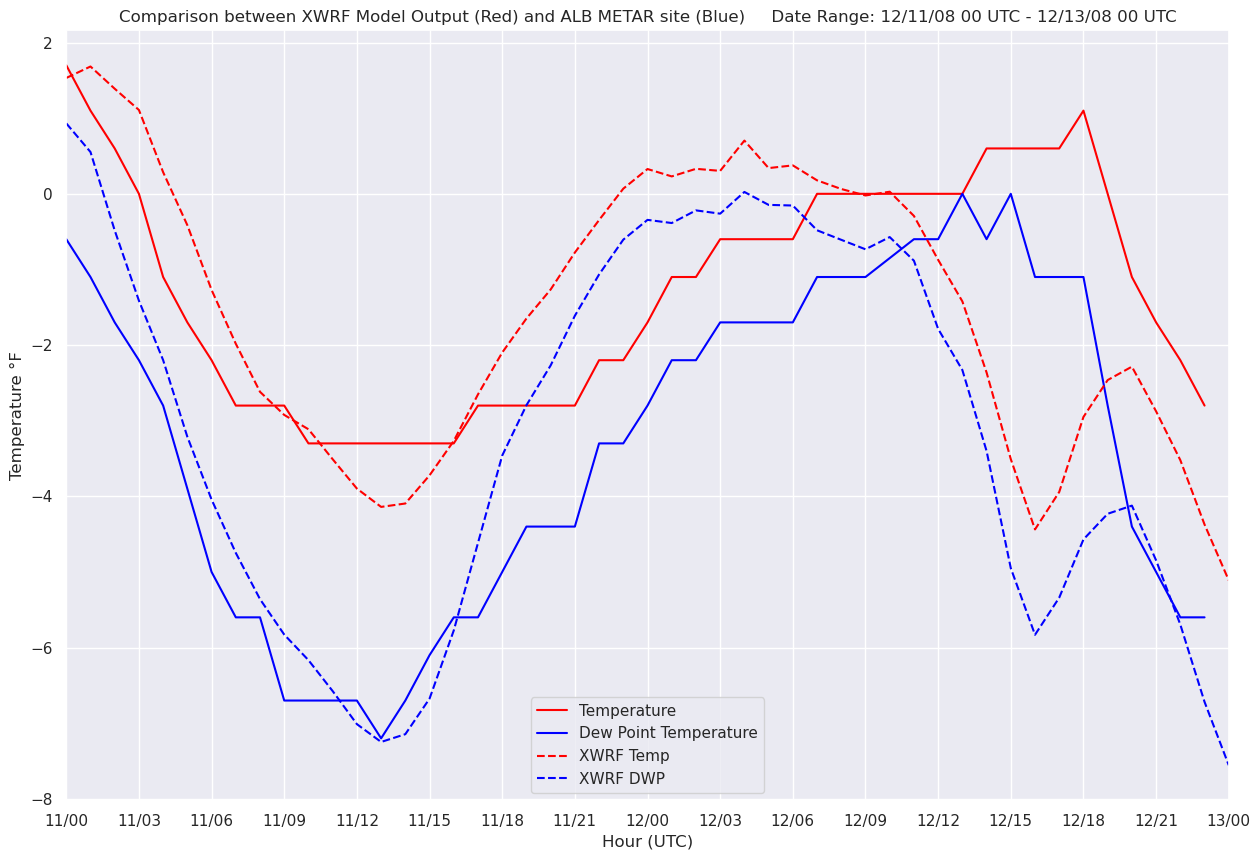

In [35]:
sns.set()

fig, ax = plt.subplots(figsize=(15, 10))

# Improve on the default ticking

ax.xaxis.set_major_locator(HourLocator(interval=3))
hoursFmt = DateFormatter('%d/%H')
ax.xaxis.set_major_formatter(hoursFmt)

ax.plot(dfSub['DATETIME'], var1, color='red', label='Temperature')
ax.plot(dfSub['DATETIME'], var2, color='blue', label='Dew Point Temperature')
ax.plot(ds.Time, T2, color='red', linestyle='--', label='XWRF Temp')
ax.plot(ds.Time, ds.dew_point_temperature, color='blue', linestyle='--', label='XWRF DWP')

ax.set_title(f'Comparison between XWRF Model Output (Red) and ALB METAR site (Blue)     Date Range: {sTimeStr} - {eTimeStr}')



ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Temperature °F')
ax.set_xlim(startTime, endTime)
ax.legend(loc='best')



#### Creating a Meteogram to plot our comparison for Sea-Level Pressure for METAR Data and the XWRF Model output

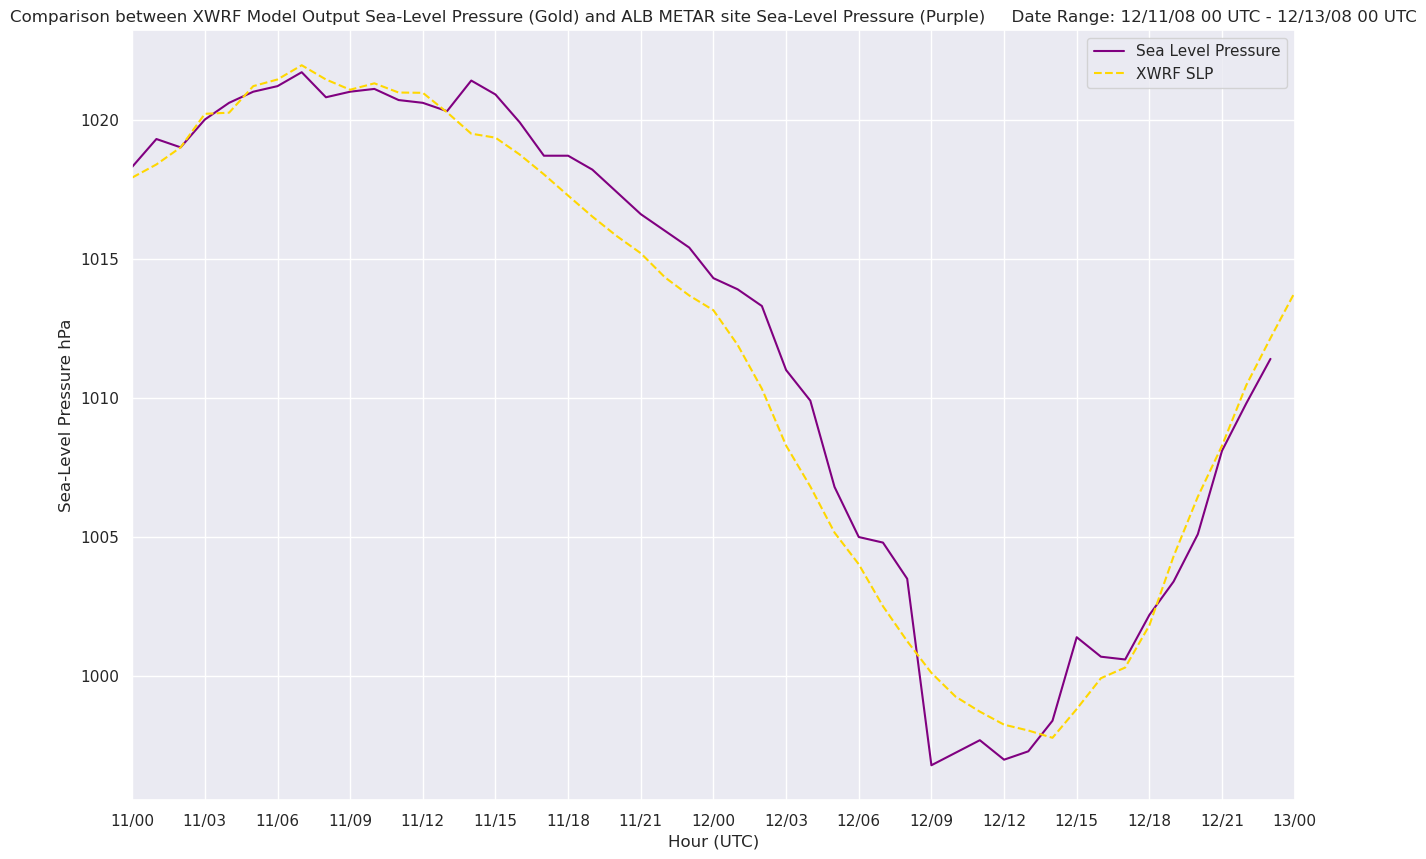

In [27]:
sns.set()

fig, ax = plt.subplots(figsize=(15, 10))

# Improve on the default ticking

ax.xaxis.set_major_locator(HourLocator(interval=3))
hoursFmt = DateFormatter('%d/%H')
ax.xaxis.set_major_formatter(hoursFmt)

ax.plot(dfSub['DATETIME'], var3, color='purple', label='Sea Level Pressure')
ax.plot(ds.Time, SLP, color='gold', linestyle='--',label='XWRF SLP')
ax.set_title(f'Comparison between XWRF Model Output Sea-Level Pressure (Gold) and ALB METAR site Sea-Level Pressure (Purple)     Date Range: {sTimeStr} - {eTimeStr}')



ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Sea-Level Pressure hPa')
ax.set_xlim(startTime, endTime)
ax.legend(loc='best')



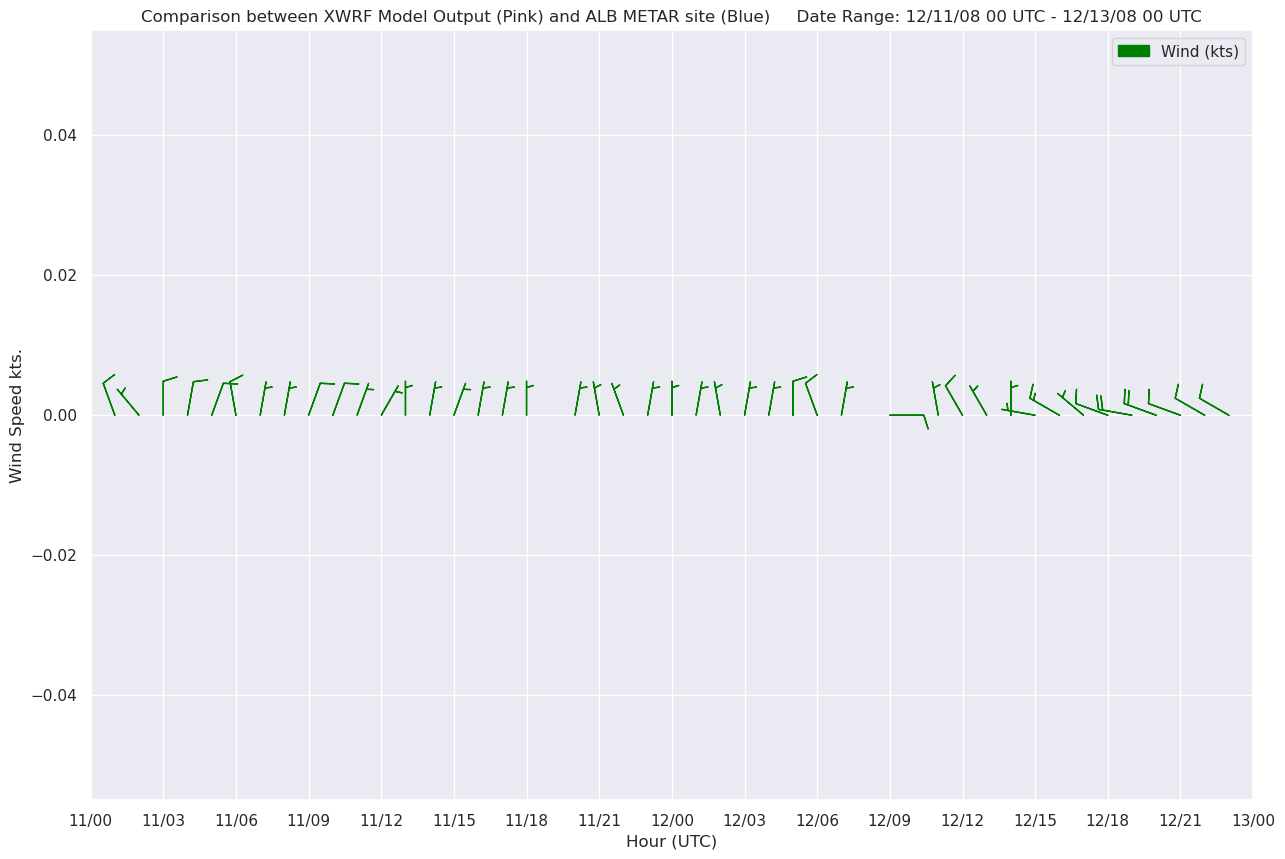

In [34]:
sns.set()

fig, ax = plt.subplots(figsize=(15, 10))

# Improve on the default ticking

ax.xaxis.set_major_locator(HourLocator(interval=3))
hoursFmt = DateFormatter('%d/%H')
ax.xaxis.set_major_formatter(hoursFmt)

y = np.zeros_like(u)

ax.barbs(dfSub['DATETIME'], y,u, v, color='green', label='Wind (kts)')
##ax.plot(ds.Time, DRCT, color='black', linestyle='--', label='XWRF Wind Direction')
ax.set_title(f'Comparison between XWRF Model Output (Pink) and ALB METAR site (Blue)     Date Range: {sTimeStr} - {eTimeStr}')



ax.set_xlabel('Hour (UTC)')
ax.set_ylabel('Wind Speed kts.')
ax.set_xlim(startTime, endTime)
ax.legend(loc='best')

